Predicting Stroke By Problematic Factors


Introduction

Stroke is a serious medical condition with potentially life-altering consequences, making awareness, prevention, and early intervention is vital in reducing its impact on individuals and public health. Through utilizing existing data related to stroke, we aim to predict whether family glucose level and BMI have a relevant effect on causing strokes. The data set we will use consists of more than 15,000 records and 22 fields of stroke prediction datasets such as “Age”, “Gender”, “Smoking Status”, “BMI” and “Average Glucose Level” . We will be using KNN classification to predict if the value of “BMI” and “Average Glucose Level” have a correlation with strokes. 

Methods and Results 
1. Load Stroke Prediction data set into Jupyter notebook.
2. Split data into training sets and testing sets 
3. Split the training set in preparation for cross validation. 
4. Create a recipe and standardize the data (center and scale).
5. Perform classification.
6. Put the data together in workflow.
7. Check the accuracy of k values (from 1 to 100 with an interval of 5). 
8. Compare the accuracy values against each other using a line graph. 
9. Find the k value with the highest accuracy and repeat steps from  4 to 6
10. Plot a scatter plot with the two predictor variable to show how they related to diagnosis result

We will conduct our data analysis by first loading the data set into the Jupyter Notebook. We will then split our data into training sets and testing sets, which is followed by splitting data into training sets and testing sets. After creating a recipe, we will standardize our data center and scale our data (standardize). Next, we will perform the classification by putting the standardized data into a workflow. The workflow will help organize our data by putting together the recipe and our model. With the workflow, we will find out the accuracy of k value in the range of 1-100 with an interval of 5 and visualize the accuracy distribution with a scatterplot. After finding out the highest accuracy, we will use its k value to perform classification again. Finally, we will visualize the correlation among two predictor variables and diagnosis results.

The variables and columns we want to utilize for conducting the data analysis should be relevant and helpful for making an accurate prediction. The ‘Average Glucose Level’ and ‘BMI’ were two numerical variables that we incorporated. Although other variables such as ‘Patient ID’, ‘Patient Name’, ‘Age’ and ‘Gender’ were also considered important variables, we did not use them since they were categorical. Furthermore, we determined variables such as ‘Marital Status’, ‘Work Type’, and ‘Residence Type’ as irrelevant and unnecessary categorical variables that do not contribute to our data analysis and making an accurate prediction. Only the two numerical variables ‘Average Glucose Level’ and ‘BMI will be incorporated into making our data analysis as they are clearly relevant and can help us predict the factors that can possibly increase or decrease the odds of causing a stroke. 

In [1]:
#installing libraries

install.packages("janitor")
library(tidyverse)
library(repr)
library(rvest)
library(stringr)
library(janitor)
library(repr)
library(tidymodels)
install.packages('kknn')

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘rvest’


The following object is masked from ‘package:readr’:

    guess_encoding



Attaching package: ‘janitor’


The following objects are masked from ‘package:stats’:

    chisq.test, fisher.test


── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔

In [2]:
#Our dataset can successfully be loaded into R

stroke_original <- read_csv('https://raw.githubusercontent.com/YiruJiang/Stroke_Prediction/main/stroke_prediction_dataset.csv') |> 
    clean_names()

head(stroke_original, 5)

#We selected the relevant variables and the top 5000 rows.
stroke <- stroke_original |> 
    select(average_glucose_level, body_mass_index_bmi, diagnosis) |> 
    slice(1:4000)

head(stroke, 5)

Rows: 15000 Columns: 22
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (14): Patient Name, Gender, Marital Status, Work Type, Residence Type, S...
dbl  (8): Patient ID, Age, Hypertension, Heart Disease, Average Glucose Leve...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


patient_id,patient_name,age,gender,hypertension,heart_disease,marital_status,work_type,residence_type,average_glucose_level,⋯,alcohol_intake,physical_activity,stroke_history,family_history_of_stroke,dietary_habits,stress_levels,blood_pressure_levels,cholesterol_levels,symptoms,diagnosis
<dbl>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,⋯,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>
18153,Mamooty Khurana,56,Male,0,1,Married,Self-employed,Rural,130.91,⋯,Social Drinker,Moderate,0,Yes,Vegan,3.48,140/108,"HDL: 68, LDL: 133","Difficulty Speaking, Headache",Stroke
62749,Kaira Subramaniam,80,Male,0,0,Single,Self-employed,Urban,183.73,⋯,Never,Low,0,No,Paleo,1.73,146/91,"HDL: 63, LDL: 70","Loss of Balance, Headache, Dizziness, Confusion",Stroke
32145,Dhanush Balan,26,Male,1,1,Married,Never Worked,Rural,189.00,⋯,Rarely,High,0,Yes,Paleo,7.31,154/97,"HDL: 59, LDL: 95","Seizures, Dizziness",Stroke
6154,Ivana Baral,73,Male,0,0,Married,Never Worked,Urban,185.29,⋯,Frequent Drinker,Moderate,0,No,Paleo,5.35,174/81,"HDL: 70, LDL: 137","Seizures, Blurred Vision, Severe Fatigue, Headache, Confusion",No Stroke
48973,Darshit Jayaraman,51,Male,1,1,Divorced,Self-employed,Urban,177.34,⋯,Rarely,Low,0,Yes,Pescatarian,6.84,121/95,"HDL: 65, LDL: 68",Difficulty Speaking,Stroke


average_glucose_level,body_mass_index_bmi,diagnosis
<dbl>,<dbl>,<chr>
130.91,22.37,Stroke
183.73,32.57,Stroke
189.00,20.32,Stroke
185.29,27.50,No Stroke
177.34,29.06,Stroke


In [3]:
#setting the seed 
set.seed(12345)

#splitting the dataset into testing and training sets 

stroke <- mutate(stroke, diagnosis = as_factor(diagnosis))

stroke_split <- initial_split(stroke, prop = 0.75, strata = diagnosis)
stroke_train <- training(stroke_split)
stroke_test <- testing(stroke_split)

head(stroke_train, 3)
nrow(stroke_train)
head(stroke_test, 3)
nrow(stroke_test)

average_glucose_level,body_mass_index_bmi,diagnosis
<dbl>,<dbl>,<fct>
185.29,27.50,No Stroke
94.90,36.74,No Stroke
136.06,25.19,No Stroke


[1] 2999

average_glucose_level,body_mass_index_bmi,diagnosis
<dbl>,<dbl>,<fct>
177.34,29.06,Stroke
77.83,28.20,No Stroke
72.99,30.10,Stroke


[1] 1001

In [4]:
#Cross Validation -What is the best K 


#Splitting our training set in preperation for cross validation. 
validation_split <- initial_split(stroke_train, prop = 0.75, strata = diagnosis) 
stroke_subtrain <- training(validation_split) 
stroke_validation <- testing(validation_split)

#Create the standardization recipe 
stroke_recipe_validation <- recipe(diagnosis ~ ., data = stroke_subtrain) |> 
    step_scale(all_predictors()) |> 
    step_center(all_predictors()) 

#Create Model 
knn_spec_validation <- nearest_neighbor(weight_func = 'rectangular', neighbors = tune()) |> 
    set_engine('kknn') |> 
    set_mode('classification') 

#Create workflow
knn_fit_validation <- workflow() |> 
    add_recipe(stroke_recipe_validation) |> 
    add_model(knn_spec_validation) |> 
    fit(data = stroke_validation)

Warning message:
“tune samples were requested but there were 750 rows in the data. 745 will be used.”


In [5]:
k_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 5)) 

#creating the vfold 
stroke_vfold <- vfold_cv(stroke_train, v = 5, strata = diagnosis) 


knn_results <- workflow() |> 
    add_recipe(stroke_recipe_validation) |> 
    add_model(knn_spec_validation) |> 
    tune_grid(resamples = stroke_vfold, grid = k_vals) |> 
    collect_metrics()

In [6]:
accuracies <- knn_results |> 
    filter(.metric == 'accuracy')|> 
    arrange(by = desc(mean)) 

head(accuracies, 5)

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
81,accuracy,binary,0.5231669,5,0.006699685,Preprocessor1_Model17
86,accuracy,binary,0.5204964,5,0.009502983,Preprocessor1_Model18
41,accuracy,binary,0.5185064,5,0.008836600,Preprocessor1_Model09
96,accuracy,binary,0.5174992,5,0.007897434,Preprocessor1_Model20
36,accuracy,binary,0.5158370,5,0.005551964,Preprocessor1_Model08


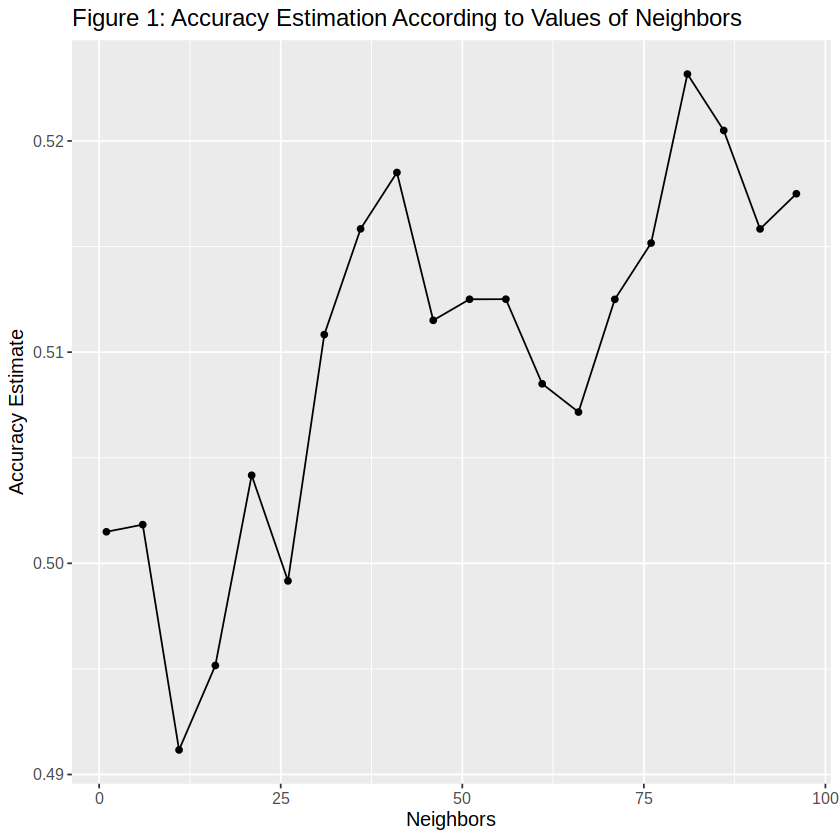

In [7]:
accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") + 
  theme(text = element_text(size = 12)) +
  ggtitle("Figure 1: Accuracy Estimation According to Values of Neighbors")

accuracy_vs_k

#We can see that the K = 81 has the best accuracy. 

In [8]:
knn_spec <- nearest_neighbor(weight_func = 'rectangular', neighbors = 81) |> 
    set_engine('kknn') |> 
    set_mode('classification') 

knn_recipe <- recipe(diagnosis ~ ., data = stroke_train) |> 
    step_scale(all_predictors()) |> 
    step_center(all_predictors()) 
                     
knn_workflow <- workflow() |> 
    add_recipe(knn_recipe) |> 
    add_model(knn_spec) |>
    fit(data = stroke_train) 
                     
stroke_predictions <- predict(knn_workflow, stroke_test) |> 
    bind_cols(stroke_test) 
                     

head(stroke_predictions, 5)

.pred_class,average_glucose_level,body_mass_index_bmi,diagnosis
<fct>,<dbl>,<dbl>,<fct>
Stroke,177.34,29.06,Stroke
No Stroke,77.83,28.20,No Stroke
Stroke,72.99,30.10,Stroke
No Stroke,111.23,28.83,No Stroke
Stroke,72.85,37.58,No Stroke


In [9]:
prediction_accuracy <- stroke_predictions |> 
    metrics(truth = diagnosis, estimate = .pred_class)

prediction_accuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.50849151
kap,binary,0.01682112


In [10]:
confusion_matrix <- stroke_predictions |> 
    conf_mat(truth = diagnosis, estimate = .pred_class)

confusion_matrix

           Truth
Prediction  Stroke No Stroke
  Stroke       248       245
  No Stroke    247       261

In [11]:
correct_labels <- 248 + 261
incorrect_labels <- 247 + 245

accuracy <- correct_labels / (correct_labels + incorrect_labels) 
precision <- 248 / (248 + 245) 
recall <- 248 / (248 + 247)

accuracy 
precision
recall

[1] 0.5084915

[1] 0.5030426

[1] 0.5010101

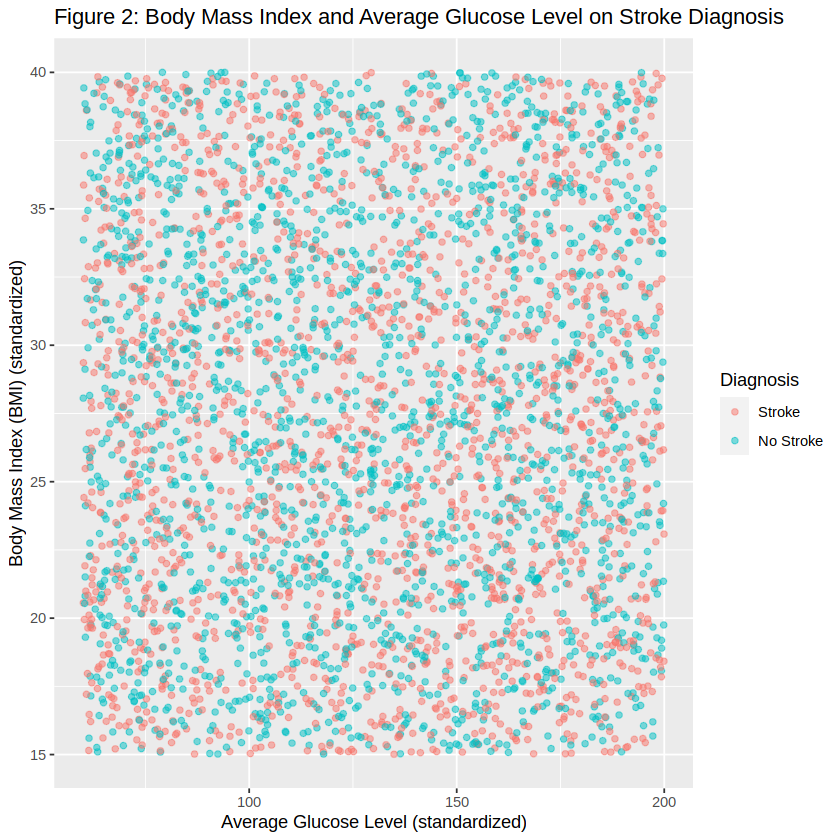

In [12]:
visualization <- stroke |> 
    ggplot(aes(x = average_glucose_level, y = body_mass_index_bmi, color = diagnosis)) + 
    geom_point(alpha = 0.5) + 
    labs(x = 'Average Glucose Level (standardized)', y = 'Body Mass Index (BMI) (standardized)', color = 'Diagnosis') + 
    ggtitle('Figure 2: Body Mass Index and Average Glucose Level on Stroke Diagnosis')

visualization

Discussion

The result we found is that we cannot predict if a person has a stroke by using the two numerical variables, ‘BMI’ and ‘Average glucose level’. The accuracy of our prediction is only about 0.5, which means that our prediction is too low and inaccurate for it to be used. It is an unexpected result because we initially expected it to be much more accurate. The scatter plot is also hard to show any significant correlation among the two predictor variables and the diagnosis result.

However, we found two previous studies that state body weight and glucose levels have some correlation with the risk of suffering strokes. In the first study, researcher Liu et al. (2018) summarized that when in the BMI range 23–24 kg/m2, both overweight and obesity can increase the risk of stroke with the nadir of the dose–response curve. In addition, Benn et al. (2021) who conducted the second study claimed that genetically high plasma glucose can contribute to increased risk of ischaemic stroke. 

To compare our findings with the previous two studies above, it seems our findings lack evidence to support their findings. The reason why we got these unideal results is that our variables have some limitations on predicting strokes. For example, BMI is a simple measure based on height and weight and does not account for variations in body composition. It may not accurately reflect the distribution of body fat or the presence of other metabolic risk factors. Besides, people's bodies respond differently to glucose levels and BMI. Some individuals with seemingly healthy glucose levels and BMI may still be at risk due to other factors like genetics or lifestyle choices. In this case, future questions that other researchers can further explore can be: Are there specific measures of body composition that may provide more accurate predictions than BMI alone? Also, given that individuals may respond differently to glucose levels, what other factors, such as genetics or lifestyle choices, contribute to stroke risk independently of glucose levels?

References

Benn, M., Emanuelsson, F., Tybjærg-Hansen, A. et al. Impact of high glucose levels and glucose lowering on risk of ischaemic stroke: a Mendelian randomisation study and meta-analysis. Diabetologia 64, 1492–1503 (2021). https://doi.org/10.1007/s00125-021-05436-0

Liu, X., Zhang, D., Liu, Y., Sun, X., Hou, Y., Wang, B., Ren, Y., Zhao, Y., Han, C., Cheng, C.,        Liu, F., Shi, Y., Chen, X., Liu, L., Chen, G., Hong, S., Zhang, M., & Hu, D. (2018). A J-shaped relation of BMI and stroke: Systematic review and dose–response meta-analysis of 4.43 million participants. Nutrition, Metabolism, and Cardiovascular Diseases, 28(11), 1092-1099. https://doi.org/10.1016/j.numecd.2018.07.004
